Dataset loaded from: Mall_Customers.csv — 200 rows, 5 columns


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


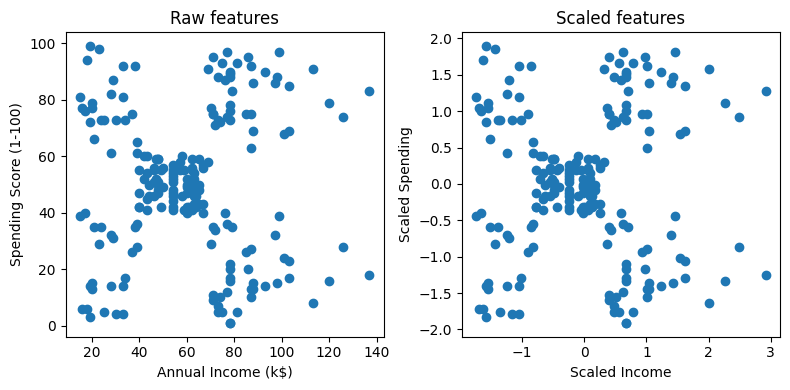

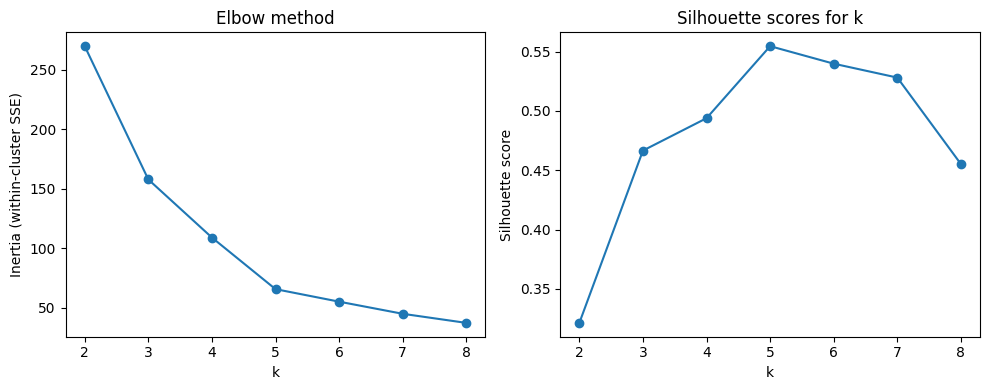

Recommended k (highest silhouette among tested 2-8): 5 (silhouette=0.555)

Cluster counts & means:
              Annual Income (k$)               Spending Score (1-100)         \
                           count   mean median                  count   mean   
KMeansCluster                                                                  
0                             81  55.30   54.0                     81  49.52   
1                             39  86.54   79.0                     39  82.13   
2                             22  25.73   24.5                     22  79.36   
3                             35  88.20   85.0                     35  17.11   
4                             23  26.30   25.0                     23  20.91   

                      
              median  
KMeansCluster         
0               50.0  
1               83.0  
2               77.0  
3               16.0  
4               17.0  

Cluster centroids (original scale):
   Annual Income (k$)  Spending Score (

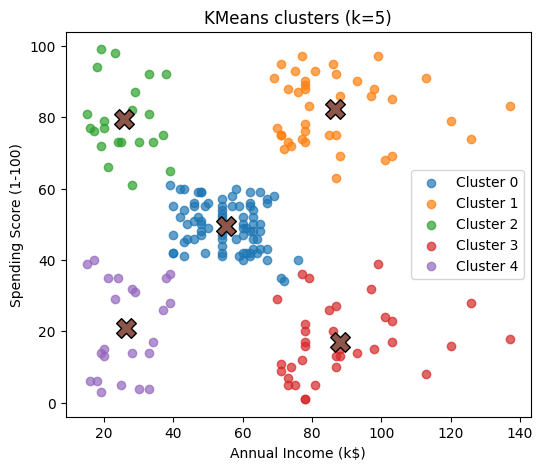


Average spending per cluster:
   KMeansCluster  count  mean_spending  median_spending
0              0     81          49.52             50.0
1              1     39          82.13             83.0
2              2     22          79.36             77.0
3              3     35          17.11             16.0
4              4     23          20.91             17.0

DBSCAN found 1 clusters (noise labeled -1).


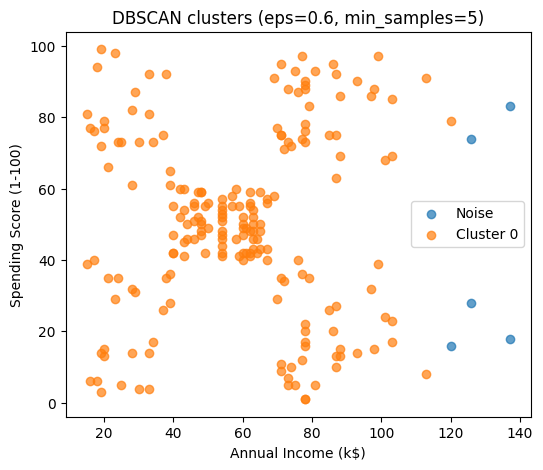


Saved dataset with cluster labels to: mall_customers_with_clusters.csv


In [ ]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# 1) Load dataset if available, else synthesize a Mall-like dataset
filename = "Mall_Customers.csv"
if os.path.exists(filename):
    df = pd.read_csv(filename)
    loaded_from = filename
else:
    np.random.seed(42)
    n = 200
    genders = np.random.choice(['Male','Female'], size=n)
    ages = np.clip((np.random.normal(38,10,size=n)).astype(int), 16, 70)
    income = np.clip((np.random.normal(60,25,size=n)).astype(int), 15, 140)   # k$
    spending = np.clip((np.random.normal(50,25,size=n)).astype(int), 1, 100) # 1-100
    df = pd.DataFrame({
        'CustomerID': np.arange(1, n+1),
        'Gender': genders,
        'Age': ages,
        'Annual Income (k$)': income,
        'Spending Score (1-100)': spending
    })
    loaded_from = "synthetic dataset (Mall-like)"

print(f"Dataset loaded from: {loaded_from} — {df.shape[0]} rows, {df.shape[1]} columns")
display(df.head())

# 2) Select features for clustering
features = ['Annual Income (k$)', 'Spending Score (1-100)']
X = df[features].values

# 3) Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4) Exploratory scatter (raw and scaled)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1])
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Raw features')

plt.subplot(1,2,2)
plt.scatter(X_scaled[:,0], X_scaled[:,1])
plt.xlabel('Scaled Income')
plt.ylabel('Scaled Spending')
plt.title('Scaled features')
plt.tight_layout()
plt.show()

# 5) Elbow & Silhouette (k = 2..8)
inertia = []
sil_scores = []
K_range = range(2,9)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(K_range), inertia, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia (within-cluster SSE)')
plt.title('Elbow method')

plt.subplot(1,2,2)
plt.plot(list(K_range), sil_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores for k')
plt.tight_layout()
plt.show()

# 6) Choose k: pick k with highest silhouette from tested range
best_k = K_range[np.argmax(sil_scores)]
print(f"Recommended k (highest silhouette among tested 2-8): {best_k} (silhouette={max(sil_scores):.3f})")

# 7) Fit final KMeans and show cluster summary
kmeans = KMeans(n_clusters=int(best_k), random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X_scaled)
df['KMeansCluster'] = labels_km

# cluster centers back to original scale
centers_scaled = kmeans.cluster_centers_
centers_orig = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_orig, columns=features)
centers_df['Cluster'] = centers_df.index

print("\nCluster counts & means:")
print(df.groupby('KMeansCluster')[features].agg(['count','mean','median']).round(2))

print("\nCluster centroids (original scale):")
print(centers_df)

# 8) 2D scatter with clusters + centroids
plt.figure(figsize=(6,5))
for c in sorted(df['KMeansCluster'].unique()):
    mask = df['KMeansCluster']==c
    plt.scatter(df.loc[mask,'Annual Income (k$)'], df.loc[mask,'Spending Score (1-100)'], label=f'Cluster {c}', alpha=0.7)
plt.scatter(centers_df[features[0]], centers_df[features[1]], marker='X', s=200, edgecolor='k', linewidth=1)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title(f'KMeans clusters (k={best_k})')
plt.legend()
plt.show()

# 9) Average spending per cluster
spending_by_cluster = df.groupby('KMeansCluster')['Spending Score (1-100)'].agg(['count','mean','median']).round(2).reset_index().rename(columns={'mean':'mean_spending','median':'median_spending'})
print("\nAverage spending per cluster:")
print(spending_by_cluster)

# 10) Bonus: DBSCAN (on scaled features) - eps is heuristic; tune for your data
db = DBSCAN(eps=0.6, min_samples=5)
labels_db = db.fit_predict(X_scaled)
df['DBSCANCluster'] = labels_db
n_db_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
print(f"\nDBSCAN found {n_db_clusters} clusters (noise labeled -1).")

plt.figure(figsize=(6,5))
unique_labels = sorted(set(labels_db))
for lab in unique_labels:
    mask = labels_db == lab
    label_name = f'Noise' if lab == -1 else f'Cluster {lab}'
    plt.scatter(X[mask,0], X[mask,1], label=label_name, alpha=0.7)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('DBSCAN clusters (eps=0.6, min_samples=5)')
plt.legend()
plt.show()

# 11) Save dataset with cluster labels
out_csv = "mall_customers_with_clusters.csv"
df.to_csv(out_csv, index=False)
print(f"\nSaved dataset with cluster labels to: {out_csv}")
